#<span style="color:#2E86C1; font-size:26px; font-weight:bold;">A Graph-Based Drug Discovery Platform using NetworkX and ArangoDB</span>

### **Graph-Based Drug Discovery using Open-Source Data**  
We use **open-source data** from [DrugCentral](https://drugcentral.org/).  

For the **live website**, click [here](your_live_website_link).


Our approach to **graph-based drug discovery** is highly creative and original because it optimally balances biomedical complexity and computational efficiency. Here’s why our solution stands out:

1. **Innovative Graph Representation**
Instead of treating data as isolated tables, our approach maps complex biological relationships into a structured graph. This allows for:

**Multi-layered connectivity**, **linking drugs**, **proteins**, **side effects**, and **approvals**.

Better insights into drug-target interactions through centrality and clustering.

2. **Smart Data Minimization**
Unlike traditional graph-based approaches that overload with excessive data, our approach uses very large datasets but optimally filters and structures them to extract only the most relevant and high-impact connections

**AQL Agent** → Converts queries into ArangoDB’s AQL, enabling structured, knowledge-driven exploration.

**cuGraph Agent** → Runs GPU-accelerated graph analytics, uncovering deep insights fast.

3. Cutting-Edge Computational Stack
By combining ArangoDB, NetworkX, and cuGraph, we leverage:

Graph database efficiency (**ArangoDB**) for complex queries.
Scalable analytics (**cuGraph**) for high-performance graph computations.

Interoperability with NetworkX, allowing smooth prototyping and scaling.





<br>

<p align="center">
    <img src="https://arangodb.com/wp-content/uploads/2016/05/ArangoDB_logo_avocado_@1.png" style="height: 50px;">
    <img src="https://www.nvidia.com/content/dam/en-zz/Solutions/about-nvidia/logo-and-brand/02-nvidia-logo-color-grn-500x200-4c25-p@2x.png" style="height: 50px;">
    <img src="https://rapids.ai/images/RAPIDS-logo.png" style="height: 50px;">
    <img src="https://avatars.githubusercontent.com/u/388785?s=200&v=4" style="height: 50px;">
</p>

## **Overview**  
This notebook explores how **graph-based techniques** can enhance **drug discovery** by leveraging **NetworkX** and **ArangoDB**. We construct a **biological interaction network** to identify **potential drug candidates** efficiently.  

---


In [ ]:
!pip install --upgrade langchain langchain-community langchain-openai langgraph openai nx-arangodb

In [2]:
# 2. Check if you have an NVIDIA GPU
# Note: If this returns "command not found", then GPU-based algorithms via cuGraph are unavailable

!nvidia-smi
!nvcc --version

Sun Mar  9 12:35:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# 3. Install nx-cugraph via pip
# Note: Only enable this installation if the step above is working!

!pip install cugraph-cu12 nx-cugraph-cu12 cuxfilter-cu12 --extra-index-url https://pypi.nvidia.com # Requires CUDA-capable GPU

NX_CUGRAPH_AUTOCONFIG=True

# **Package Installation & setup**  

Before we begin constructing the graph and analyzing relationships, we need to set up the necessary libraries. The following imports include:  

- **Graph Processing** → `networkx`, `nx_arangodb` (for handling graph data in ArangoDB).  
- **Database Connectivity** → `arango` (to interact with ArangoDB).  
- **Data Handling & Visualization** → `pandas`, `numpy`, `matplotlib`.  
- **Randomization & Text Processing** → `randint`, `re`.  
- **AI-Driven Graph Querying & Reasoning** → `LangGraph`, `LangChain`, and `ArangoGraphQAChain`.  

These tools establish the **agentic framework** for **graph-based drug discovery**, enabling intelligent reasoning over biological interaction networks.


In [4]:
import networkx as nx
import nx_arangodb as nxadb

from arango import ArangoClient

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import re

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool

[12:36:54 +0000] [INFO]: NetworkX-cuGraph is available.
INFO:nx_arangodb:NetworkX-cuGraph is available.


### **Dataset Preparation**  

To build the **graph-based drug discovery platform**, we first need to **load and process datasets** containing crucial pharmaceutical information. The following datasets are used:  

- **Drug Structure Data** → `structures.csv`  
- **Drug-Target Interactions** → `act_table_full.csv`  
- **Drug Approvals** → `approval.csv`  
- **Side Effects Data** → `faers.csv`  
- **Protein Structures** → `pdb.csv`  

These datasets will be processed and integrated into the graph for further analysis.


In [5]:
import pandas as pd

structures_df = pd.read_csv("structures.csv")  # Drug data
act_table_df = pd.read_csv("act_table_full.csv")  # Drug-target interactions
approval_df = pd.read_csv("approval.csv")  # Drug approvals
faers_df = pd.read_csv("faers.csv")  # Side effects
pdb_df = pd.read_csv("pdb.csv")  # Protein structures

In [6]:
print("Structures DataFrame:")
print(structures_df.head())

print("\nAct Table DataFrame:")
print(act_table_df.head())

print("\nApproval DataFrame:")
print(approval_df.head())

print("\nFAERS DataFrame:")
print(faers_df.head())

print("\nPDB DataFrame:")
print(pdb_df.head())


Structures DataFrame:
   cd_id     cd_formula  cd_molweight    id  clogp  alogs    cas_reg_no  \
0   5596     C23H17FN6O       412.428  5392   2.27  -4.89  1029712-80-8   
1   5597     C29H31N7O3       525.613  5393   3.21  -4.25  2152628-33-4   
2   5598  C24H21BrFN5O2       510.367  5394   5.06  -4.94  1442472-39-0   
3   5482     C13H19N3O7       329.309  5377  -1.13  -1.81           NaN   
4   5599      C18H23FO2       289.381  5395   3.63  -3.93    94153-53-4   

     tpsa  lipinski                  name  ...  rotb  \
0   85.07       0.0            capmatinib  ...   4.0   
1  112.04       1.0         selpercatinib  ...   8.0   
2   86.36       1.0            ripretinib  ...   5.0   
3  140.92       0.0          molnupiravir  ...   6.0   
4   40.46       0.0  fluoroestradiol F 18  ...   0.0   

                                              molimg   o_n oh_nh  \
0  \x89504e470d0a1a0a0000000d49484452000003200000...   7.0   1.0   
1  \x89504e470d0a1a0a0000000d49484452000003200000...  

#### **Data Cleaning & Preprocessing**  

After loading the datasets, it is essential to **clean and preprocess** the data for consistency. The following steps are performed:  

- **Handling Missing Values:**  
  - Rows with missing critical identifiers (`id`, `struct_id`, `target_id`, etc.) are **removed**.  
  - Other missing values are **filled** with defaults (e.g., `"Unknown"` for text, `0` for numeric values).  

- **Ensuring Consistent Data Types:**  
  - Key identifiers (`id`, `struct_id`, `target_id`, etc.) are **converted to string format** to maintain uniformity across datasets.  

This step ensures that the data is **ready for integration into the graph**.  


In [7]:
structures_df.dropna(subset=["id"], inplace=True)
act_table_df.dropna(subset=["struct_id", "target_id"], inplace=True)
approval_df.dropna(subset=["id", "struct_id"], inplace=True)
faers_df.dropna(subset=["struct_id", "meddra_code"], inplace=True)
pdb_df.dropna(subset=["struct_id", "pdb"], inplace=True)

structures_df.fillna({"name": "Unknown", "cd_molweight": 0, "smiles": "Unknown"}, inplace=True)
act_table_df.fillna({"target_name": "Unknown", "gene": "Unknown", "swissprot": "Unknown", "act_value": 0, "moa": "Unknown"}, inplace=True)
approval_df.fillna({"approval": "Unknown", "applicant": "Unknown", "orphan": "Unknown"}, inplace=True)
faers_df.fillna({"meddra_name": "Unknown", "llr": 0, "llr_threshold": "Unknown"}, inplace=True)
pdb_df.fillna({"chain_id": "Unknown", "ligand_id": "Unknown", "exp_method": "Unknown"}, inplace=True)

structures_df["id"] = structures_df["id"].astype(str)
act_table_df["struct_id"] = act_table_df["struct_id"].astype(str)
act_table_df["target_id"] = act_table_df["target_id"].astype(str)
approval_df["id"] = approval_df["id"].astype(str)
approval_df["struct_id"] = approval_df["struct_id"].astype(str)
faers_df["struct_id"] = faers_df["struct_id"].astype(str)
faers_df["meddra_code"] = faers_df["meddra_code"].astype(str)
pdb_df["struct_id"] = pdb_df["struct_id"].astype(str)
pdb_df["pdb"] = pdb_df["pdb"].astype(str)


# Graph Construction & Representation

This section focuses on building a graph structure using **NetworkX**. The nodes represent different entities such as drugs, targets, approvals, side effects, and protein structures, while the edges define relationships like interactions, approvals, and side effects.


In [8]:
import networkx as nx

G = nx.Graph()

for _, row in structures_df.iterrows():
    G.add_node(row["id"], type="Drug", label=row.get("name"), mol_weight=row["cd_molweight"], smiles=row["smiles"])

for _, row in act_table_df.iterrows():
    G.add_node(row["target_id"], type="Target", label=row.get("target_name"), gene=row["gene"], swissprot=row["swissprot"])

for _, row in approval_df.iterrows():
    G.add_node(row["id"], type="Approval", label=row.get("id"), status=row["approval"], applicant=row["applicant"], orphan=row["orphan"])

for _, row in faers_df.iterrows():
    G.add_node(row["meddra_code"], type="SideEffect", label=row.get("meddra_name"), llr=row["llr"], safety_data=row["llr_threshold"])

for _, row in pdb_df.iterrows():
    G.add_node(row["pdb"], type="ProteinStructure", label=row.get("pdb"), chain_id=row["chain_id"], ligand=row["ligand_id"], exp_method=row["exp_method"])

for _, row in act_table_df.iterrows():
    G.add_edge(row["struct_id"], row["target_id"], relation="INTERACTS_WITH", activity=row["act_value"], moa=row["moa"])

for _, row in approval_df.iterrows():
    G.add_edge(row["struct_id"], row["id"], relation="HAS_APPROVAL", type=row["type"], applicant=row["applicant"])

for _, row in faers_df.iterrows():
    G.add_edge(row["struct_id"], row["meddra_code"], relation="HAS_SIDE_EFFECT", llr=row["llr"])

for _, row in pdb_df.iterrows():
    G.add_edge(row["struct_id"], row["pdb"], relation="BINDS_TO", ligand=row["ligand_id"], method=row["exp_method"])

missing_label_nodes = [n for n in G.nodes if "label" not in G.nodes[n]]
if missing_label_nodes:
    print(f"Nodes Missing 'label': {len(missing_label_nodes)}")
else:
    print(f"All nodes have a 'label'")

print("Final Graph Summary:")
print(f"Total Nodes: {G.number_of_nodes()}")
print(f"Total Edges: {G.number_of_edges()}")


All nodes have a 'label'
Final Graph Summary:
Total Nodes: 24960
Total Edges: 395379


This code prints the total number of nodes and edges in the constructed graph. It serves as a validation step to confirm that all entities (such as drugs, targets, approvals, side effects, and protein structures) and their relationships have been successfully added to the graph.


**Graph Visualization using NetworkX spring_layout (CPU-based)**

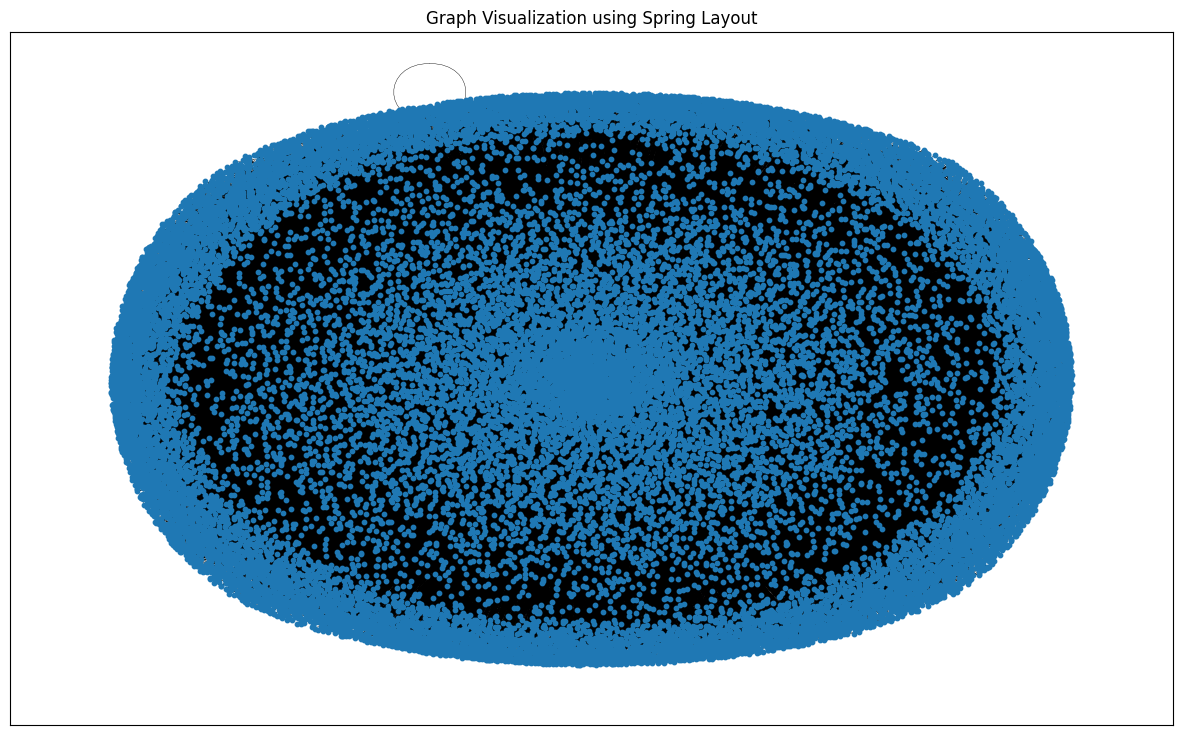

In [72]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

edges_df = nx.to_pandas_edgelist(G)
edges_df = edges_df[['source', 'target']]  # Keep only required columns

edges_df['source'] = edges_df['source'].astype(str)
edges_df['target'] = edges_df['target'].astype(str)

G_nx = nx.from_pandas_edgelist(edges_df, source='source', target='target')

pos = nx.spring_layout(G_nx, iterations=50, seed=1721, k=0.2)

plt.figure(figsize=(15, 9))
nx.draw_networkx(G_nx, pos, node_size=10, with_labels=False, width=0.3)
plt.title("Graph Visualization using Spring Layout")
plt.show()


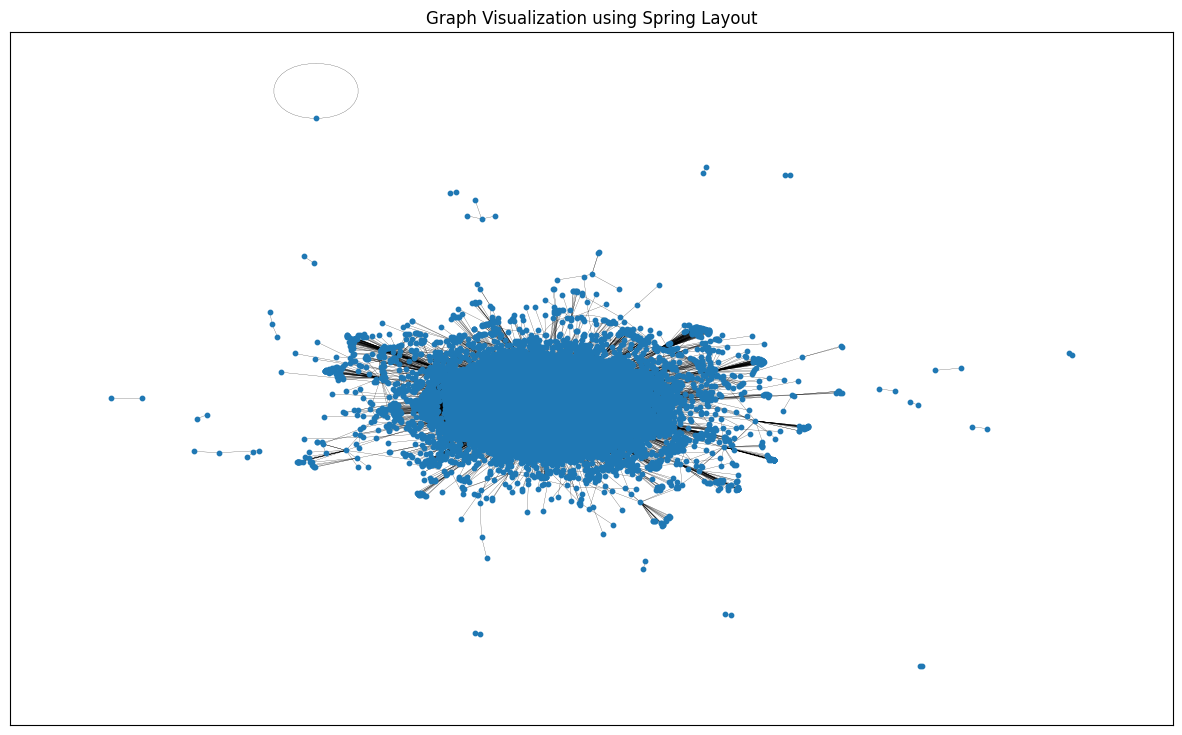

In [70]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

edges_df = nx.to_pandas_edgelist(G)
edges_df = edges_df[['source', 'target']]  # Keep only required columns

edges_df['source'] = edges_df['source'].astype(str)
edges_df['target'] = edges_df['target'].astype(str)

G_nx = nx.from_pandas_edgelist(edges_df, source='source', target='target')

pos = nx.spring_layout(G_nx, iterations=15, seed=1721)

plt.figure(figsize=(15, 9))
nx.draw_networkx(G_nx, pos, node_size=10, with_labels=False, width=0.15)
plt.title("Graph Visualization using Spring Layout")
plt.show()


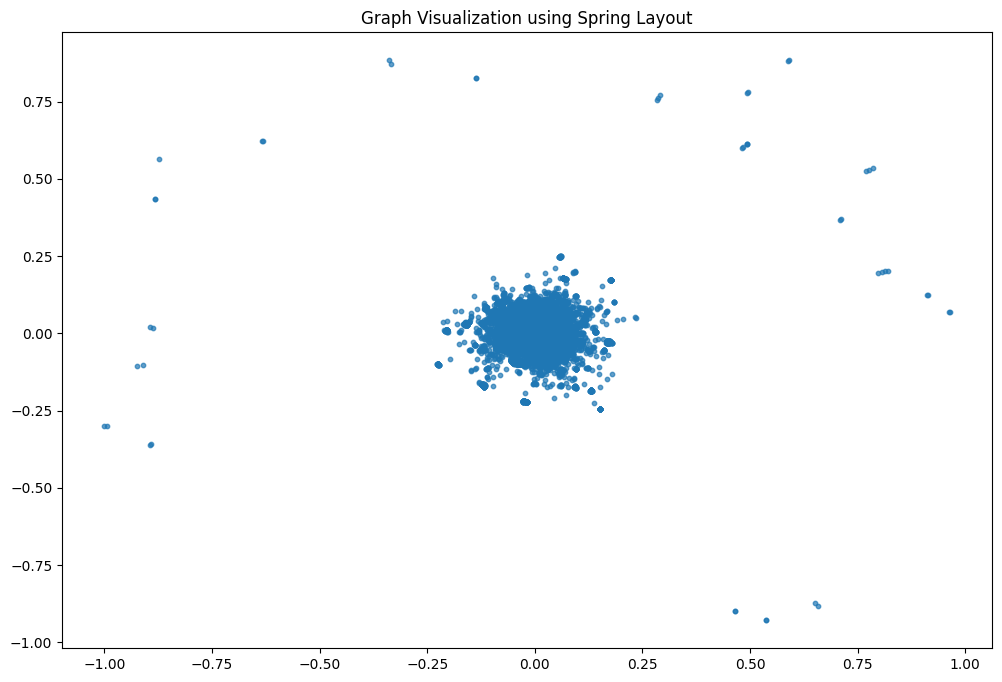

In [69]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

edges_df = nx.to_pandas_edgelist(G)
edges_df = edges_df[['source', 'target']]  # Keep only required columns

edges_df['source'] = edges_df['source'].astype(str)
edges_df['target'] = edges_df['target'].astype(str)

G_nx = nx.from_pandas_edgelist(edges_df, source='source', target='target')

pos = nx.spring_layout(G_nx)

pos_df = pd.DataFrame(pos).T

plt.figure(figsize=(12, 8))
plt.scatter(pos_df[0], pos_df[1], s=10, alpha=0.7)
plt.title("Graph Visualization using Spring Layout")
plt.show()

**Graph Visualization Using cuGraph RAPIDS (ForceAtlas2) (GPU-accelerated alternative)**


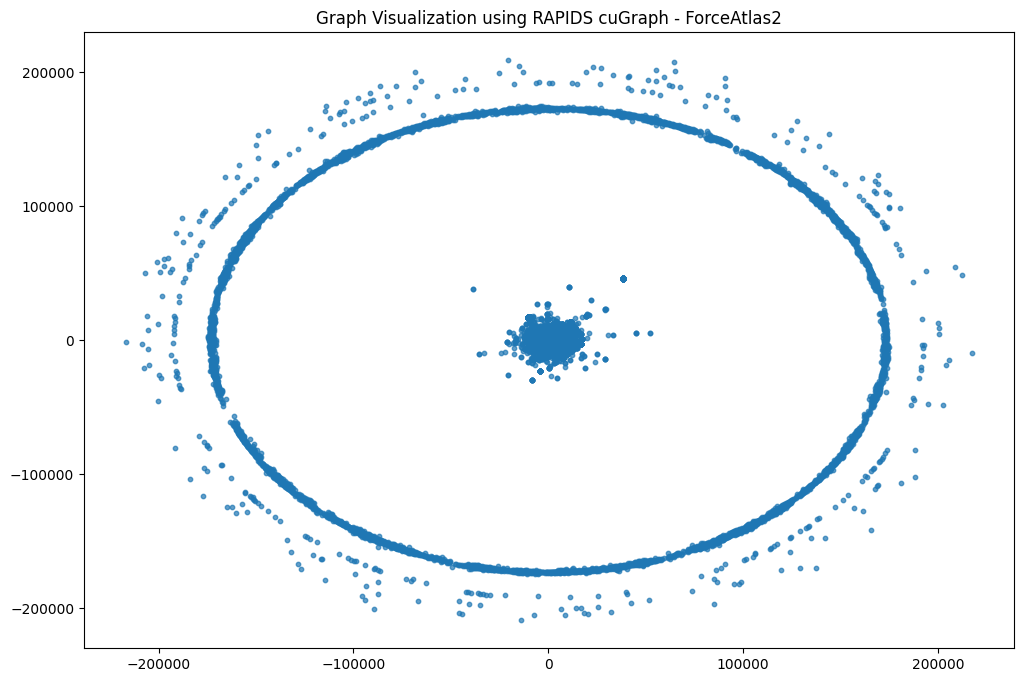

In [67]:
import networkx as nx
import cudf
import cugraph
import matplotlib.pyplot as plt

G_nx = G

edges_df = nx.to_pandas_edgelist(G_nx)

edges_df = edges_df[['source', 'target']]

edges_df['source'] = edges_df['source'].astype(str)
edges_df['target'] = edges_df['target'].astype(str)

edges_gdf = cudf.DataFrame(edges_df)

G_cugraph = cugraph.Graph()
G_cugraph.from_cudf_edgelist(edges_gdf, source='source', destination='target')

fa2_pos = cugraph.force_atlas2(G_cugraph)

fa2_pos = fa2_pos.to_pandas()

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.scatter(fa2_pos['x'], fa2_pos['y'], s=10, alpha=0.7)
plt.title("Graph Visualization using RAPIDS cuGraph - ForceAtlas2")
plt.show()


In [73]:
print("Graph Nodes:", G.number_of_nodes())
print("Graph Edges:", G.number_of_edges())
density = nx.density(G)
print("Graph Density:", density)

Graph Nodes: 24960
Graph Edges: 395379
Graph Density: 0.0012693220728148009


This code initializes a connection to an ArangoDB database using the `ArangoClient`. It specifies the database host, authentication credentials (username and password), and a verification flag. The `db` object represents the database connection, and printing it helps confirm that the connection has been successfully established.


In [74]:
from arango import ArangoClient
db = ArangoClient(hosts="https://024b49e82b10.arangodb.cloud:8529").db(username="root", password="uULxwodDJ5QHX1ahfK6T", verify=True)

print(db)

<StandardDatabase _system>


This code initializes a graph in ArangoDB using the `nx_arangodb` library. It creates an instance of `nxadb.Graph`, which allows integration between NetworkX and ArangoDB. The parameters used are:

- `name="drug_discovery"`: Specifies the name of the graph in ArangoDB.
- `db=db`: Passes the previously established ArangoDB database connection.
- `incoming_graph_data=G`: Loads the existing NetworkX graph (`G`) into ArangoDB.
- `write_batch_size=10000`: Sets the batch size for writing data to optimize performance.
- `overwrite_graph=True`: Ensures that any existing graph with the same name is replaced.

This step effectively transfers the in-memory NetworkX graph to a persistent ArangoDB database for further querying and analysis.


In [75]:
import nx_arangodb as nxadb

G_adb = nxadb.Graph(
    name="drug_discovery",
    db=db,
    incoming_graph_data=G,
    write_batch_size=10000,
    overwrite_graph=True
)

(NX → ADB): Edges ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━  94% (370001/395379) 0:00:18
     ADB Import: 'drug_discovery_node_to_drug_discovery_node' (10000) ▰▱▱▱▱▱▱ 0:00:00

(NX → ADB): Edges ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━  96% (380001/395379) 0:00:19
     ADB Import: 'drug_discovery_node_to_drug_discovery_node' (10000) ▰▰▰▰▰▰▰ 0:00:00

(NX → ADB): Edges ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% (395379/395379) 0:00:20
     ADB Import: 'drug_discovery_node_to_drug_discovery_node' (5378) ▰▰▰▱▱▱▱ 0:00:00

[2025/03/09 14:43:28 +0000] [718] [INFO] - adbnx_adapter: Created ArangoDB 'drug_discovery' Graph
INFO:adbnx_adapter:Created ArangoDB 'drug_discovery' Graph


### Reconnecting to the Existing Graph in ArangoDB

This code reconnects to the previously created "drug_discovery" graph in ArangoDB using `nx_arangodb`. Instead of creating a new graph or importing data again, it simply establishes a connection to the existing graph stored in the database.

- `nxadb.Graph(name="drug_discovery", db=db)`: This initializes a `nxadb.Graph` object, linking it to the already existing "drug_discovery" graph in ArangoDB.
- `print(G_adb)`: Outputs the graph object to confirm the successful connection.

This step ensures that we can interact with the stored graph without needing to recreate it.


In [76]:
# 2. Re-connect to the same Graph

import nx_arangodb as nxadb

G_adb = nxadb.Graph(name="drug_discovery", db=db)

print(G_adb)

[14:45:45 +0000] [INFO]: Graph 'drug_discovery' exists.
INFO:nx_arangodb:Graph 'drug_discovery' exists.
[14:45:46 +0000] [INFO]: Default node type set to 'drug_discovery_node'
INFO:nx_arangodb:Default node type set to 'drug_discovery_node'


Graph named 'drug_discovery' with 24960 nodes and 395379 edges


#<span style="color:#2E86C1; font-size:26px; font-weight:bold;">ArangoDB drug_discovery Graph withn 250 and 1250 Limit</span>  
<br>

<p align="center">
    <img src="https://res.cloudinary.com/dach5nfj2/image/upload/v1741531922/lh51ouaa3jiyqtdjj82d.png" style="height: 50px;">
    <img src="https://res.cloudinary.com/dach5nfj2/image/upload/v1741531865/exbsgo3slo8kiddtso0l.png" style="height: 50px;">
</p>


### Counting Nodes and Edges in ArangoDB

This code executes AQL (ArangoDB Query Language) queries to count the total number of nodes and edges in the "drug_discovery" graph stored in ArangoDB.

- **Counting Nodes**:  
  ```python
  query_nodes = "RETURN LENGTH(drug_discovery_node)"
  result_nodes = db.aql.execute(query_nodes)
  print(f"Total Nodes in ArangoDB: {list(result_nodes)[0]}")


In [77]:
# Count total nodes
query_nodes = "RETURN LENGTH(drug_discovery_node)"
result_nodes = db.aql.execute(query_nodes)
print(f"Total Nodes in ArangoDB: {list(result_nodes)[0]}")

# Count total edges
query_edges = "RETURN LENGTH(drug_discovery_node_to_drug_discovery_node)"
result_edges = db.aql.execute(query_edges)
print(f"Total Edges in ArangoDB: {list(result_edges)[0]}")


Total Nodes in ArangoDB: 24960
Total Edges in ArangoDB: 395379


### Querying Drug Information in ArangoDB

This AQL query retrieves detailed information about a specific drug (`fluoroestradiol`) from the `drug_discovery_node` collection in ArangoDB. The query extracts:
1. **Drug Details**
2. **Target Interactions**
3. **Approval Information**
4. **Side Effects**
5. **Protein Binding Data**


In [79]:
import json

query_id = """
LET drug_key = "13"

LET drug = (
    FOR d IN drug_discovery_node
        FILTER d.label == 'fluoroestradiol'
        RETURN d
)[0]

LET targets = (
    FOR edge IN drug_discovery_node_to_drug_discovery_node
        FILTER edge._from == CONCAT("drug_discovery_node/", drug_key) AND edge.relation == "INTERACTS_WITH"
        FOR target IN drug_discovery_node
            FILTER target._key == PARSE_IDENTIFIER(edge._to).key
            RETURN MERGE(target, { "relation": edge.relation, "activity": edge.activity, "moa": edge.moa })
)

LET approvals = (
    FOR edge IN drug_discovery_node_to_drug_discovery_node
        FILTER edge._from == CONCAT("drug_discovery_node/", drug_key) AND edge.relation == "HAS_APPROVAL"
        FOR approval IN drug_discovery_node
            FILTER approval._key == PARSE_IDENTIFIER(edge._to).key
            RETURN MERGE(approval, { "relation": edge.relation, "type": edge.type, "applicant": edge.applicant })
)

LET side_effects = (
    FOR edge IN drug_discovery_node_to_drug_discovery_node
        FILTER edge._from == CONCAT("drug_discovery_node/", drug_key) AND edge.relation == "HAS_SIDE_EFFECT"
        FOR se IN drug_discovery_node
            FILTER se._key == PARSE_IDENTIFIER(edge._to).key
            RETURN MERGE(se, { "relation": edge.relation, "llr": edge.llr })
)

LET proteins = (
    FOR edge IN drug_discovery_node_to_drug_discovery_node
        FILTER edge._from == CONCAT("drug_discovery_node/", drug_key) AND edge.relation == "BINDS_TO"
        FOR protein IN drug_discovery_node
            FILTER protein._key == PARSE_IDENTIFIER(edge._to).key
            RETURN MERGE(protein, { "relation": edge.relation, "ligand": edge.ligand, "method": edge.method })
)

RETURN { "drug": drug, "targets": targets, "approvals": approvals, "side_effects": side_effects, "proteins": proteins }
"""
result_id = db.aql.execute(query_id)

for res in result_id:
    print(json.dumps(res, indent=4))


{
    "drug": null,
    "targets": [
        {
            "_id": "drug_discovery_node/2443",
            "_key": "2443",
            "_rev": "_jVraDTO-A0",
            "gene": "PTGFR",
            "label": "Prostaglandin F2-alpha receptor",
            "mol_weight": 334.332,
            "smiles": "CO[C@]12[C@H]3N[C@H]3CN1C1=C([C@H]2COC(N)=O)C(=O)C(N)=C(C)C1=O",
            "swissprot": "PF2R_BOVIN",
            "type": "Target",
            "moa": "Unknown",
            "activity": 7.01,
            "relation": "INTERACTS_WITH"
        },
        {
            "_id": "drug_discovery_node/3440",
            "_key": "3440",
            "_rev": "_jVraDTm-_m",
            "gene": "PTGFR",
            "label": "Prostaglandin F2-alpha receptor",
            "mol_weight": 462.5,
            "smiles": "N[C@@H](C(=O)N[C@H]1[C@H]2SCC(CSC3=CNN=N3)=C(N2C1=O)C(O)=O)C1=CC=C(O)C=C1",
            "swissprot": "PF2R_HUMAN",
            "type": "Target",
            "moa": 1,
            "activity": 8.

#**Agentic Framework**

This section initializes the **ArangoGraph** using the connected database. The **ArangoGraph** object enables seamless interaction with the ArangoDB graph database, allowing for efficient storage, retrieval, and querying of relationships between drug discovery entities. This setup lays the foundation for graph-based operations in the subsequent steps.

In [80]:
arango_graph = ArangoGraph(db)

It sets the API key using `os.environ`,
Ensure that a valid API key is used instead of `"sk-p"`.  

In [155]:
import os

os.environ["OPENAI_API_KEY"] = "sk-proj-xxx"

This function, `text_to_aql_to_text`, performs the following tasks:

- Converts a user query into an AQL query for ArangoDB.
- Ensures compliance with the drug discovery schema by using the correct node and edge collections.
- Uses `e.relation` instead of `e.label` when referencing edge relationships.
- Generates an optimized AQL query with case-sensitive handling for drug names.
- Executes the query and returns both the generated AQL and the retrieved graph data.


In [83]:
@tool
def text_to_aql_to_text(query: str):
    """
    Executes an AQL query on ArangoDB using the drug discovery schema.

    **Schema Overview:**
    - **Nodes (drug_discovery_node) these are not label and can be accessed by .type**:
      - Drug: _key, label, mol_weight, smiles
      - Target: _key, label, gene, swissprot
      - Approval: _key, label, status, applicant, type
      - SideEffect: _key, label, llr
      - ProteinStructure: _key, label, ligand, method

    - **Edges (drug_discovery_node_to_drug_discovery_node)**:
      - INTERACTS_WITH: Drug → Target (activity, moa)
      - HAS_APPROVAL: Drug → Approval (type, applicant)
      - HAS_SIDE_EFFECT: Drug → SideEffect (llr)
      - BINDS_TO: Drug → ProteinStructure (ligand, method)

    Do not assume information that is not explicitly stated in the schema. Ensure the AQL query follows the exact structure given above

    **Important Constraint:**
    - Always use `e.relation` **(if it exists)** instead of `e.label` when writing AQL queries.
    - Ensure the generated AQL query retrieves relevant **drug discovery** information **accurately and efficiently**.
    """

    schema_context = """
    You are working with an ArangoDB database for drug discovery.

    - **Node Collection**: `drug_discovery_node`
    - **Edge Collection**: `drug_discovery_node_to_drug_discovery_node`

    **Edge Relationships:**
    - `INTERACTS_WITH`, `HAS_APPROVAL`, `HAS_SIDE_EFFECT`, `BINDS_TO`

    Always use `e.relation` to reference edge relationships.

    Always use these collections and relationships using (e.relation if exists) when writing AQL queries.
    """

    prompt = f"""
    {schema_context}

    User Query: "{query}"

    Generate an optimized AQL query using `drug_discovery_node` (for nodes) and
    `drug_discovery_node_to_drug_discovery_node` (for edges). Ensure the query
    retrieves relevant drug discovery information accurately.

    **Case Sensitivity Notice:**
    - Drug names are always **processed in lowercase** for accurate matching.

    **Generated AQL Query:**
    """

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    result = llm.invoke(prompt).content

    # Extract AQL Query
    aql_query = re.search(r"```aql\n(.*?)\n```", result, re.DOTALL)
    aql_query = aql_query.group(1) if aql_query else "No AQL query found."

    # Execute AQL Query
    aql_result = db.aql.execute(aql_query)

    return f"**AQL Query:**\n```aql\n{aql_query}\n```\n\n**Graph Data:** {list(aql_result)}"

This function `text_to_cugraph_algorithm_to_text` enables the execution of cuGraph algorithms on a graph derived from ArangoDB. The process involves:

-**Query Interpretation**: An LLM determines the most suitable cuGraph algorithm based on the user’s query.
-**Code Generation**: The LLM produces executable Python code that applies the chosen algorithm to G_cu, the cuGraph representation of the ArangoDB dataset.
-**Code Execution**: The generated code is executed, and FINAL_RESULT is captured while handling potential errors.
-**Result Formatting**: The output is converted into a concise, natural language response aligned with the original query.

If a query requires an undirected graph, the function ensures proper conversion. If the requested algorithm is not supported, an error is returned.



In [150]:
import cugraph
import cudf

edges_df = nx.to_pandas_edgelist(G)

edges_df = edges_df[['source', 'target']]
edges_df['source'] = edges_df['source'].astype(str)
edges_df['target'] = edges_df['target'].astype(str)

edges_gdf = cudf.DataFrame(edges_df)

G_cugraph = cugraph.Graph(directed=True)
G_cugraph.from_cudf_edgelist(edges_gdf, source='source', destination='target')

@tool
def text_to_cugraph_algorithm_to_text(query: str):
    """Invokes a cuGraph algorithm on the ArangoDB Graph.

    Steps:
    1. Select a valid algorithm from the list below.
    2. Generate Python code using `G_cu` (convert to undirected if needed).
    3. Ensure `FINAL_RESULT` is a concise answer.

    **Valid Algorithms:**
    - **Centrality:** pagerank, betweenness_centrality, degree_centrality, closeness_centrality, eigenvector_centrality
    - **Paths:** bfs, dijkstra, sssp
    - **Community:** louvain, leiden, label_propagation
    - **Prediction:** jaccard, adamic_adar
    - **Clustering:** k_core, triangle_count, connected_components
    - **Traversal:** bfs, dfs
    - **Matching:** overlap_coefficients
    - **Embeddings:** node2vec, graph_sage

    If the query doesn't match an algorithm, return an error.
    """

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

    ######################
    print("1) Generating cuGraph code")

    text_to_cugraph = llm.invoke(f"""
    I have a cuGraph Graph called `G_cu`. It has been constructed from an
    ArangoDB dataset using NetworkX and cuGraph. The schema is: {arango_graph.schema}

    I have the following graph analysis query: {query}.

    You must select an appropriate algorithm **ONLY** from the following list:

    - **Centrality:** pagerank, betweenness_centrality, degree_centrality, closeness_centrality, eigenvector_centrality
    - **Shortest Paths:** bfs, dijkstra, sssp
    - **Community Detection:** louvain, leiden, label_propagation
    - **Link Prediction:** jaccard, adamic_adar
    - **Clustering:** k_core, triangle_count, connected_components
    - **Traversal:** bfs, dfs
    - **Graph Matching:** overlap_coefficients
    - **Embeddings:** node2vec, graph_sage

    **Important Instructions:**
    - If an algorithm requires an **undirected graph**, convert `G_cu` using `G_undirected = G_cu.to_undirected()`.
    - Ensure `FINAL_RESULT` is a **concise** and **meaningful** answer to the query.
    - If the query **does not match** any known algorithms, return an appropriate error message.
    - The output should be **valid Python code**, executable with `exec()`.
    - Do **NOT** include any explanations or markdown formatting.

    Your code:
    """).content

    text_to_cugraph_cleaned = re.sub(r"^```python\n|```$", "", text_to_cugraph, flags=re.MULTILINE).strip()

    print('-'*10)
    print(text_to_cugraph_cleaned)
    print('-'*10)

    ######################
    print("\n2) Executing cuGraph code")
    global_vars = {"G_cu": G_cu, "cugraph": cugraph, "cudf": cudf}
    local_vars = {}

    try:
        exec(text_to_cugraph_cleaned, global_vars, local_vars)
        text_to_cugraph_final = text_to_cugraph
    except AttributeError as e:
        if "input graph must be undirected" in str(e):
            return "ERROR: This algorithm requires an undirected graph. Convert `G_cu` using `G_undirected = G_cu.to_undirected()` and try again."
        else:
            return f"EXEC ERROR: {e}"
    except Exception as e:
        return f"EXEC ERROR: {e}"

    print('-'*10)
    FINAL_RESULT = local_vars.get("FINAL_RESULT", "No valid result generated.")
    print(f"FINAL_RESULT: {FINAL_RESULT}")
    print('-'*10)

    ######################
    print("3) Formulating final answer")

    cugraph_to_text = llm.invoke(f"""
        I have a cuGraph Graph called `G_cu`. It has the following schema: {arango_graph.schema}

        I have the following graph analysis query: {query}.

        I have executed the following Python code to help me answer my query:

        ---
        {text_to_cugraph_final}
        ---

        The `FINAL_RESULT` variable is set to the following: {FINAL_RESULT}.

        Based on my original Query and FINAL_RESULT, generate a **short and concise** response
        that directly answers the query.

        Your response:
    """).content

    return cugraph_to_text


<ipython-input-150-92f4e08640d7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df['source'] = edges_df['source'].astype(str)


### Formatting Query Results into an HTML Table  

This script takes a query containing structured drug-side effect data and formats it into a clean, structured HTML table using OpenAI's API. It ensures that only the given information is presented without additional modifications. The output is further enhanced with CSS styling for better readability. Regular expressions are used to remove unnecessary Markdown formatting from the API response. The `text_to_table` function acts as a tool to generate the final formatted table.


In [85]:
from openai import OpenAI

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def get_table(query):
    prompt = """
    You are tasked with formatting the query response into a clean, structured table in HTML format. Remember the table is structured and contains only the information available in the query. Do not write anything explicitly from your side.

    Query: `Graph-Based Response:
    Here are the top 5 side effects for drugs with a molecular weight greater than 500:

    1. **Cyanocobalamin**
       - Side Effect: Uterine perforation
       - LLR: 17495.347

    2. **Cyanocobalamin**
       - Side Effect: Thirst
       - LLR: 5482.597

    3. **Insulin Glargine**
       - Side Effect: Thirst
       - LLR: 5482.597

    4. **Somatropin**
       - Side Effect: Thirst
       - LLR: 5482.597

    5. **Edoxaban**
       - Side Effect: Thirst
       - LLR: 5482.597

    These results show the drugs and their associated side effects, sorted by the log-likelihood ratio (LLR) of the side effects`

    It will generate the table with the following format but in HTML:

    <table>
    <tr>
        <th>Drug</th>
        <th>LLR</th>
        <th>Side Effect</th>
    </tr>
    <tr>
        <td>Cyanocobalamin</td>
        <td>17495.347</td>
        <td>Uterine perforation</td>
    </tr>
    <tr>
        <td>Cyanocobalamin</td>
        <td>5482.597</td>
        <td>Thirst</td>
    </tr>
    <tr>
        <td>Insulin Glargine</td>
        <td>5482.597</td>
        <td>Thirst</td>
    </tr>
    <tr>
        <td>Somatropin</td>
        <td>5482.597</td>
        <td>Thirst</td>
    </tr>
    <tr>
        <td>Edoxaban</td>
        <td>5482.597</td>
        <td>Thirst</td>
    </tr>
    </table>
    """

    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "developer", "content": prompt},
            {"role": "user", "content": query}
        ]
    )

    completion_content = completion.choices[0].message.content

    import re

    table_html = re.sub(r'```html\n|\n```', '', completion_content)

    table_html = """
    <style>
        table {
            width: 100%;
            border-collapse: collapse;
            margin: 20px 0;
            padding: 10px;
            text-align: left;
        }
        th, td {
            border: 1px solid #ddd;
            padding: 8px;
        }
    </style>
    """ + table_html

    return table_html

@tool
def text_to_table(query: str):
    """
    It will generate the table but only execute this agent if the query specifically mention to generate the table.

    **Functionality Overview:**
    - The function receives a query as input.
    - It calls the `get_table` function to process the query and format the result into a structured HTML table.
    - The table is enriched with CSS styles to improve its visual presentation, including borders, padding, and text alignment.

    **Return:**
    - This function returns the query's results in a structured HTML table format with added CSS styles.

    **Parameters:**
    - `query` (str): The query input, typically in a text format that will be used for data extraction and display.

    **Example Usage:**
    ```python
    query = "Here are the top 5 side effects for drugs with a molecular weight greater than 500."
    table_html = generate_table_from_query(query)
    print(table_html)
    """

    formatted_table = get_table(query)

    return f"Here is the formatted table:\n\n{formatted_table}"


### Querying a Graph with LangChain Agent

The `query_graph` function utilizes the LangChain agent to execute structured queries on a graph database. It employs the GPT-4o model with a zero-temperature setting for deterministic responses. The function processes user queries, ensuring the responses are derived from the graph. The agent is configured with tools such as `text_to_aql_to_text`, `text_to_nx_algorithm_to_text`, and `text_to_table` for query execution and formatting.


In [151]:
def query_graph(query: str):
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

    if "generate the table" in query.lower():
        tools = [text_to_table]
    else:
        tools = [text_to_aql_to_text, text_to_cugraph_algorithm_to_text]

    app = create_react_agent(llm, tools)
    final_state = app.invoke({"messages": [{"role": "user", "content": query}]})

    response_content = final_state["messages"][-1].content
    return f"Graph-Based Response:\n{response_content}"


#**AQL Query**

**Example AQL Natural Language Queries**

In [152]:
query_graph("Find all drugs that target the gene SLC47A1, have a side effect, and are approved")

Generated AQL Query:
 --------------------------------------------------

    
    You are working with an ArangoDB database for drug discovery.

    - **Node Collection**: `drug_discovery_node`
    - **Edge Collection**: `drug_discovery_node_to_drug_discovery_node`

    **Edge Relationships:**
    - `INTERACTS_WITH`, `HAS_APPROVAL`, `HAS_SIDE_EFFECT`, `BINDS_TO`

    Always use `e.relation` to reference edge relationships.

    Always use these collections and relationships using (e.relation if exists) when writing AQL queries.
    

    User Query: "FOR target IN drug_discovery_node
  FILTER target.type == 'Target' AND target.gene == 'SLC47A1'
  FOR e1 IN drug_discovery_node_to_drug_discovery_node
    FILTER e1.relation == 'INTERACTS_WITH' AND e1._to == target._id
    FOR drug IN drug_discovery_node
      FILTER drug._id == e1._from AND drug.type == 'Drug'
      FOR e2 IN drug_discovery_node_to_drug_discovery_node
        FILTER e2.relation == 'HAS_SIDE_EFFECT' AND e2._from == drug._

'Graph-Based Response:\nThe drugs that target the gene SLC47A1, have a side effect, and are approved are Granisetron and Irinotecan.'

In [117]:
query_graph("can you tell me what is the shortest connection between Drug glibenclamide and selpercatinib")

Generated AQL Query:
 --------------------------------------------------

    
    You are working with an ArangoDB database for drug discovery.

    - **Node Collection**: `drug_discovery_node`
    - **Edge Collection**: `drug_discovery_node_to_drug_discovery_node`

    **Edge Relationships:**
    - `INTERACTS_WITH`, `HAS_APPROVAL`, `HAS_SIDE_EFFECT`, `BINDS_TO`

    Always use `e.relation` to reference edge relationships.

    Always use these collections and relationships using (e.relation if exists) when writing AQL queries.
    

    User Query: "FOR v, e, p IN 1..10 ANY 'Drug/glibenclamide' GRAPH 'drug_discovery' FILTER v.type == 'Drug' AND v.label == 'selpercatinib' RETURN p"

    Generate an optimized AQL query using `drug_discovery_node` (for nodes) and
    `drug_discovery_node_to_drug_discovery_node` (for edges). Ensure the query
    retrieves relevant drug discovery information accurately.

    **Case Sensitivity Notice:**
    - Drug names are always **processed in lowercase

'Graph-Based Response:\nThere is no direct or indirect connection between the drug "glibenclamide" and "selpercatinib" within the current drug discovery graph database.'

In [118]:
query_graph("can you share all the drug names listed?")

Generated AQL Query:
 --------------------------------------------------

    
    You are working with an ArangoDB database for drug discovery.

    - **Node Collection**: `drug_discovery_node`
    - **Edge Collection**: `drug_discovery_node_to_drug_discovery_node`

    **Edge Relationships:**
    - `INTERACTS_WITH`, `HAS_APPROVAL`, `HAS_SIDE_EFFECT`, `BINDS_TO`

    Always use `e.relation` to reference edge relationships.

    Always use these collections and relationships using (e.relation if exists) when writing AQL queries.
    

    User Query: "FOR d IN drug_discovery_node FILTER d.type == 'Drug' RETURN d.label"

    Generate an optimized AQL query using `drug_discovery_node` (for nodes) and
    `drug_discovery_node_to_drug_discovery_node` (for edges). Ensure the query
    retrieves relevant drug discovery information accurately.

    **Case Sensitivity Notice:**
    - Drug names are always **processed in lowercase** for accurate matching.

    **Generated AQL Query:**
    


'Graph-Based Response:\nHere are the drug names listed in the database:\n\n1. Selpercatinib\n2. Fluoroestradiol F 18\n3. Remdesivir\n4. Mefuparib\n5. Forodesine\n6. Midostaurin\n7. Avapritinib\n8. Tazemetostat\n9. Rimegepant\n10. Osilodrostat\n11. Selumetinib\n12. Eptinezumab\n13. Tucatinib\n14. Bempedoic Acid\n15. Ozanimod\n16. Triamcinolone Hexacetonide\n17. Arformoterol\n18. Palbociclib\n19. Lenvatinib\n20. Acotiamide\n21. Felypressin\n22. Chlormerodrin\n23. Ombitasvir\n24. Netupitant\n25. Ledipasvir\n26. Aspartic Acid\n27. Pexidartinib\n28. Sotagliflozin\n29. Diquafosol\n30. Quizartinib\n31. Hexylcaine\n32. Insulin Glargine\n33. Imidafenacin\n34. Nintedanib\n35. Cetilistat\n36. Pretomanid\n37. Entrectinib\n38. Favipiravir\n39. Topiroxostat\n40. Asunaprevir\n41. Fedratinib\n42. Lefamulin\n43. Ipragliflozin\n44. Luseogliflozin\n45. Glatiramer Acetate\n46. Calfactant\n47. Suvorexant\n48. Istradefylline\n49. Simetride\n50. Tedizolid Phosphate\n\n...and many more. If you need the comple

In [119]:
query_graph("Which drugs are linked to Side Effect Tumour associated fever")

Generated AQL Query:
 --------------------------------------------------

    
    You are working with an ArangoDB database for drug discovery.

    - **Node Collection**: `drug_discovery_node`
    - **Edge Collection**: `drug_discovery_node_to_drug_discovery_node`

    **Edge Relationships:**
    - `INTERACTS_WITH`, `HAS_APPROVAL`, `HAS_SIDE_EFFECT`, `BINDS_TO`

    Always use `e.relation` to reference edge relationships.

    Always use these collections and relationships using (e.relation if exists) when writing AQL queries.
    

    User Query: "FOR se IN drug_discovery_node FILTER se.type == 'SideEffect' AND se.label == 'Tumour associated fever' FOR v, e IN 1..1 INBOUND se drug_discovery_node_to_drug_discovery_node FILTER e.relation == 'HAS_SIDE_EFFECT' RETURN v.label"

    Generate an optimized AQL query using `drug_discovery_node` (for nodes) and
    `drug_discovery_node_to_drug_discovery_node` (for edges). Ensure the query
    retrieves relevant drug discovery information acc

'Graph-Based Response:\nThe drugs linked to the side effect "Tumour associated fever" are:\n\n- 4133\n- Beta-lactamase\n- Transient receptor potential cation channel subfamily M member 3\n- Carbonic anhydrase 15\n- Arachidonate 15-lipoxygenase\n- Levofloxacin\n- Short transient receptor potential channel 6\n- 4958\n- Lethal factor\n- 25\n- Lenvatinib\n- Selpercatinib'

In [120]:
query_graph("Which protein structures does Drug glibenclamide bind to")

Generated AQL Query:
 --------------------------------------------------

    
    You are working with an ArangoDB database for drug discovery.

    - **Node Collection**: `drug_discovery_node`
    - **Edge Collection**: `drug_discovery_node_to_drug_discovery_node`

    **Edge Relationships:**
    - `INTERACTS_WITH`, `HAS_APPROVAL`, `HAS_SIDE_EFFECT`, `BINDS_TO`

    Always use `e.relation` to reference edge relationships.

    Always use these collections and relationships using (e.relation if exists) when writing AQL queries.
    

    User Query: "FOR d IN drug_discovery_node FILTER d.type == 'Drug' AND d.label == 'glibenclamide' FOR e IN drug_discovery_node_to_drug_discovery_node FILTER e._from == d._id AND e.relation == 'BINDS_TO' FOR p IN drug_discovery_node FILTER p._id == e._to RETURN p.label"

    Generate an optimized AQL query using `drug_discovery_node` (for nodes) and
    `drug_discovery_node_to_drug_discovery_node` (for edges). Ensure the query
    retrieves relevant dru

'Graph-Based Response:\nThe drug glibenclamide binds to the following protein structures: 4YVP, 4YVV, and 5IFU.'

In [121]:
query_graph("Which drugs with a molecular weight greater than 500 have side effects limit to top 5 result?")

Generated AQL Query:
 --------------------------------------------------

    
    You are working with an ArangoDB database for drug discovery.

    - **Node Collection**: `drug_discovery_node`
    - **Edge Collection**: `drug_discovery_node_to_drug_discovery_node`

    **Edge Relationships:**
    - `INTERACTS_WITH`, `HAS_APPROVAL`, `HAS_SIDE_EFFECT`, `BINDS_TO`

    Always use `e.relation` to reference edge relationships.

    Always use these collections and relationships using (e.relation if exists) when writing AQL queries.
    

    User Query: "FOR d IN drug_discovery_node FILTER d.type == 'Drug' AND d.mol_weight > 500 FOR e IN drug_discovery_node_to_drug_discovery_node FILTER e.relation == 'HAS_SIDE_EFFECT' AND e._from == d._id FOR s IN drug_discovery_node FILTER s._id == e._to SORT s.llr DESC LIMIT 5 RETURN {drug: d.label, side_effect: s.label, llr: s.llr}"

    Generate an optimized AQL query using `drug_discovery_node` (for nodes) and
    `drug_discovery_node_to_drug_discove

'Graph-Based Response:\nHere are the top 5 side effects for drugs with a molecular weight greater than 500:\n\n1. **Drug:** Cyanocobalamin\n   - **Side Effect:** Uterine perforation\n   - **LLR:** 17495.347\n\n2. **Drug:** Cyanocobalamin\n   - **Side Effect:** Thirst\n   - **LLR:** 5482.597\n\n3. **Drug:** Insulin Glargine\n   - **Side Effect:** Thirst\n   - **LLR:** 5482.597\n\n4. **Drug:** Somatropin\n   - **Side Effect:** Thirst\n   - **LLR:** 5482.597\n\n5. **Drug:** Edoxaban\n   - **Side Effect:** Thirst\n   - **LLR:** 5482.597\n\nThese results are sorted by the log-likelihood ratio (LLR) of the side effects.'

In [ ]:
#Other Examples

# query_graph("can you give the detail information of drug name selpercatinib")
# query_graph("can you give the detail information of side effect of drug selpercatinib")
# query_graph("Find all drugs that target the gene SLC47A1, have a side effect, and are approved")
# query_graph("Find all protein which is linked to the gene Atp2a2")
# query_graph("Find all drugs which is linked to the gene Atp2a2")
# query_graph("Which targets does Drug fluvastatin interact with?")
# query_graph("Is Drug selpercatinib approved, and by whom?")
# query_graph("What are the major drug interaction clusters")
# query_graph("Can you find drugs that interact with more than 3 targets")
# query_graph("can you tell more about the drug palbociclib")
# query_graph("can you generate the table for the following query Graph-Based Response:\nThe drug selpercatinib is approved by the following applicants:\n\n1. ELI LILLY JAPAN K.K.\n2. Eli Lilly Nederland B.V.\n3. LOXO ONCOLOGY INC")

#**CuGraph Queries**

**Example AQL Natural Language Queries**

In [122]:
query_graph("Find the most central nodes in the graph")

Generating cuGraph code...

Generated Code:
 --------------------------------------------------
import cugraph

# Calculate PageRank
pagerank_scores = cugraph.pagerank(G_cu)

# Sort the nodes by PageRank score in descending order
sorted_pagerank = pagerank_scores.sort_values(by='pagerank', ascending=False)

# Store the result in FINAL_RESULT
FINAL_RESULT = sorted_pagerank
--------------------------------------------------

Executing cuGraph code...
Execution Successful. Result:        pagerank vertex
6121   0.000984   4359
6113   0.000855   2544
422    0.000715    108
10996  0.000647    251
8509   0.000628    110
...         ...    ...
24625  0.000033   2058
24626  0.000033   3274
24627  0.000033   3846
24628  0.000033   4881
24629  0.000033   4240

[24774 rows x 2 columns]


/usr/local/lib/python3.11/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)


'Graph-Based Response:\nThe most central nodes in the graph, based on PageRank centrality, are as follows:\n\n1. Node 4359 with a PageRank of 0.000984\n2. Node 2544 with a PageRank of 0.000855\n3. Node 108 with a PageRank of 0.000715\n4. Node 251 with a PageRank of 0.000647\n5. Node 110 with a PageRank of 0.000628\n\nThese nodes are considered the most central in the graph according to the PageRank measure.'

In [125]:
query_graph("Rank drugs by their influence in the graph")

Generating cuGraph code...

Generated Code:
 --------------------------------------------------
import cugraph

# Compute PageRank
pagerank_result = cugraph.pagerank(G_cu)

# Store the result in FINAL_RESULT
FINAL_RESULT = pagerank_result
--------------------------------------------------

Executing cuGraph code...
Execution Successful. Result:        pagerank    vertex
0      0.000064  10060693
1      0.000041  10011376
2      0.000036  10030338
3      0.000040  10061178
4      0.000038  10029888
...         ...       ...
24769  0.000033  10002135
24770  0.000033      6P9Z
24771  0.000033      4DQF
24772  0.000033      1YYN
24773  0.000033  10061462

[24774 rows x 2 columns]


/usr/local/lib/python3.11/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)


'Graph-Based Response:\nThe drugs have been ranked by their influence in the graph using the PageRank algorithm. Here are the top 5 drugs with their PageRank scores:\n\n1. Drug ID: 10060693, PageRank: 0.000064\n2. Drug ID: 10011376, PageRank: 0.000041\n3. Drug ID: 10030338, PageRank: 0.000036\n4. Drug ID: 10061178, PageRank: 0.000040\n5. Drug ID: 10029888, PageRank: 0.000038\n\nIf you need more detailed information about these drugs or further analysis, please let me know!'

#**Table Generation Queries**

Responsible for Generating th HTML for the response we get from the AQL queries for visualization prospective

In [153]:
query_graph("generate the table for Graph-Based Response: Here are the top 5 side effects for drugs with a molecular weight greater than 500: 1. **Drug:** Cyanocobalamin - **Side Effect:** Uterine perforation - **LLR:** 17495.347 2. **Drug:** Cyanocobalamin - **Side Effect:** Thirst - **LLR:** 5482.597 3. **Drug:** Insulin Glargine - **Side Effect:** Thirst - **LLR:** 5482.597 4. **Drug:** Somatropin - **Side Effect:** Thirst - **LLR:** 5482.597 5. **Drug:** Edoxaban - **Side Effect:** Thirst - **LLR:** 5482.597 These results are sorted by the log-likelihood ratio (LLR) of the side effects.")

'Graph-Based Response:\nIt seems there was an issue with the API key used for generating the table. Unfortunately, I can\'t directly generate the table without the correct API access. However, I can help you format the data into a table manually. Here\'s how you can structure it:\n\n```html\n<table style="border-collapse: collapse; width: 100%;">\n  <tr>\n    <th style="border: 1px solid black; padding: 8px; text-align: left;">Drug</th>\n    <th style="border: 1px solid black; padding: 8px; text-align: left;">Side Effect</th>\n    <th style="border: 1px solid black; padding: 8px; text-align: left;">LLR</th>\n  </tr>\n  <tr>\n    <td style="border: 1px solid black; padding: 8px;">Cyanocobalamin</td>\n    <td style="border: 1px solid black; padding: 8px;">Uterine perforation</td>\n    <td style="border: 1px solid black; padding: 8px;">17495.347</td>\n  </tr>\n  <tr>\n    <td style="border: 1px solid black; padding: 8px;">Cyanocobalamin</td>\n    <td style="border: 1px solid black; paddin

#**THE END 😀**